In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
data = pd.read_csv('../data/bugs.csv')
print(f"Columns: {data.shape[1]}")
print(f"Shape: {data.shape}")
data.head()

Columns: 19
Shape: (9999, 19)


,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,BUGZILLA-294734,2005-05-18,Bugzilla-General,BUGZILLA,Emergency 2.16.10 Release,2.16.9 is broken -- many users can't enter bug...,mkanat,mkanat,fixed,1,resolved,4,2005-05-19,0,15,2005-05-19,1,blocker,6
1,OTHER_APPLICATIONS-363323,2006-12-09,DOM Inspector,OTHER_APPLICATIONS,DOM View is really inefficient with setting wh...,From comment in url:\n\nCurrent code:\nmenuite...,sdwilsh,sdwilsh,fixed,1,resolved,4,2011-06-01,0,8,2007-01-14,36,normal,2
2,SUPPORT.MOZILLA.ORG-398246,2007-10-02,General,SUPPORT.MOZILLA.ORG,Add support for custom cookies and cache headers,Adding support for custom headers and cookie n...,morgamic,morgamic,fixed,1,resolved,4,2009-11-02,0,23,2008-03-24,174,blocker,6
3,RELEASE_ENGINEERING-525991,2009-11-02,General,RELEASE_ENGINEERING,Create Major Update from 3.0.15 to 3.5.5,NaN,catlee,catlee,fixed,1,resolved,4,2013-08-12,0,7,2009-11-10,8,normal,2
4,OTHER_APPLICATIONS-318859,2005-12-02,ChatZilla,OTHER_APPLICATIONS,DCC functionality in ChatZilla isn't functional.,User-Agent: Mozilla/5.0 (Macintosh U PPC...,gijskruitbosch+bugs,dafydd,fixed,1,resolved,4,2006-02-10,0,14,2005-12-07,5,normal,2


In [3]:
print("Data Info:")
data.info()
print("\n")
print("Missing values:")
data.isnull().sum()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bug_id                9999 non-null   object
 1   creation_date         9999 non-null   object
 2   component_name        9999 non-null   object
 3   product_name          9999 non-null   object
 4   short_description     9998 non-null   object
 5   long_description      9920 non-null   object
 6   assignee_name         9999 non-null   object
 7   reporter_name         9999 non-null   object
 8   resolution_category   9999 non-null   object
 9   resolution_code       9999 non-null   int64 
 10  status_category       9999 non-null   object
 11  status_code           9999 non-null   int64 
 12  update_date           9999 non-null   object
 13  quantity_of_votes     9999 non-null   int64 
 14  quantity_of_comments  9999 non-null   int64 
 15  resolution_date       9999 

bug_id                   0
creation_date            0
component_name           0
product_name             0
short_description        1
long_description        79
assignee_name            0
reporter_name            0
resolution_category      0
resolution_code          0
status_category          0
status_code              0
update_date              0
quantity_of_votes        0
quantity_of_comments     0
resolution_date          0
bug_fix_time             0
severity_category        0
severity_code            0
dtype: int64

In [4]:
# Some columns have empty values: short_description and long_description, will check it later

# Check severity categories
print("Severity Categories:")
print("="*50)
print(data['severity_category'].value_counts())

print("\n" + "="*50)
print("Percentages:")
print((data['severity_category'].value_counts(normalize=True) * 100).round(2))

print("\n" + "="*50)
print("Severity Codes:")
print(data['severity_code'].value_counts().sort_index())

Severity Categories:
severity_category
normal      7604
major        738
critical     606
minor        541
trivial      305
blocker      205
Name: count, dtype: int64

Percentages:
severity_category
normal      76.05
major        7.38
critical     6.06
minor        5.41
trivial      3.05
blocker      2.05
Name: proportion, dtype: float64

Severity Codes:
severity_code
1     305
2    8145
4     738
5     606
6     205
Name: count, dtype: int64


In [5]:
print("Category-Code Mapping:")
print("="*60)
mapping = data.groupby(['severity_category', 'severity_code']).size().unstack(fill_value=0)
print(mapping)

print("\n" + "="*60)
print("For each category, what codes does it have?")
for cat in data['severity_category'].unique():
    codes = data[data['severity_category'] == cat]['severity_code'].unique()
    count = len(data[data['severity_category'] == cat])
    print(f"{cat:12s} → codes: {sorted(codes)} (n={count})")

Category-Code Mapping:
severity_code        1     2    4    5    6
severity_category                          
blocker              0     0    0    0  205
critical             0     0    0  606    0
major                0     0  738    0    0
minor                0   541    0    0    0
normal               0  7604    0    0    0
trivial            305     0    0    0    0

For each category, what codes does it have?
blocker      → codes: [np.int64(6)] (n=205)
normal       → codes: [np.int64(2)] (n=7604)
major        → codes: [np.int64(4)] (n=738)
minor        → codes: [np.int64(2)] (n=541)
critical     → codes: [np.int64(5)] (n=606)
trivial      → codes: [np.int64(1)] (n=305)


In [6]:
# Drop the inconsistent severity_code column
# Decision: Dropping severity_code due to data inconsistency
# - Both 'minor' and 'normal' categories map to code 2
# - Code 3 is missing entirely
# - severity_category provides clear, distinct labels for classification
# - Using severity_category as the target variable
data = data.drop('severity_code', axis=1)
print(f"Shape after dropping severity_code: {data.shape}")

# Save to a new file
data.to_csv('../data/bugs_cleaned.csv', index=False)
print(f"Cleaned data saved: {data.shape}")

Shape after dropping severity_code: (9999, 18)
Cleaned data saved: (9999, 18)


    severity_category                  product_name  count
0             blocker  ADDONS.MOZILLA.ORG_GRAVEYARD      4
1             blocker                 AUS_GRAVEYARD      1
2             blocker                      BUGZILLA     32
3             blocker          BUGZILLA.MOZILLA.ORG      3
4             blocker                      CALENDAR      2
..                ...                           ...    ...
299           trivial                      WEBSITES      1
300           trivial            WEBSITES_GRAVEYARD      2
301           trivial            WEBTOOLS_GRAVEYARD      2
302           trivial               WWW.MOZILLA.ORG     10
303           trivial     WWW.MOZILLA.ORG_GRAVEYARD      1

[304 rows x 3 columns]


<Axes: xlabel='severity_category', ylabel='Count'>

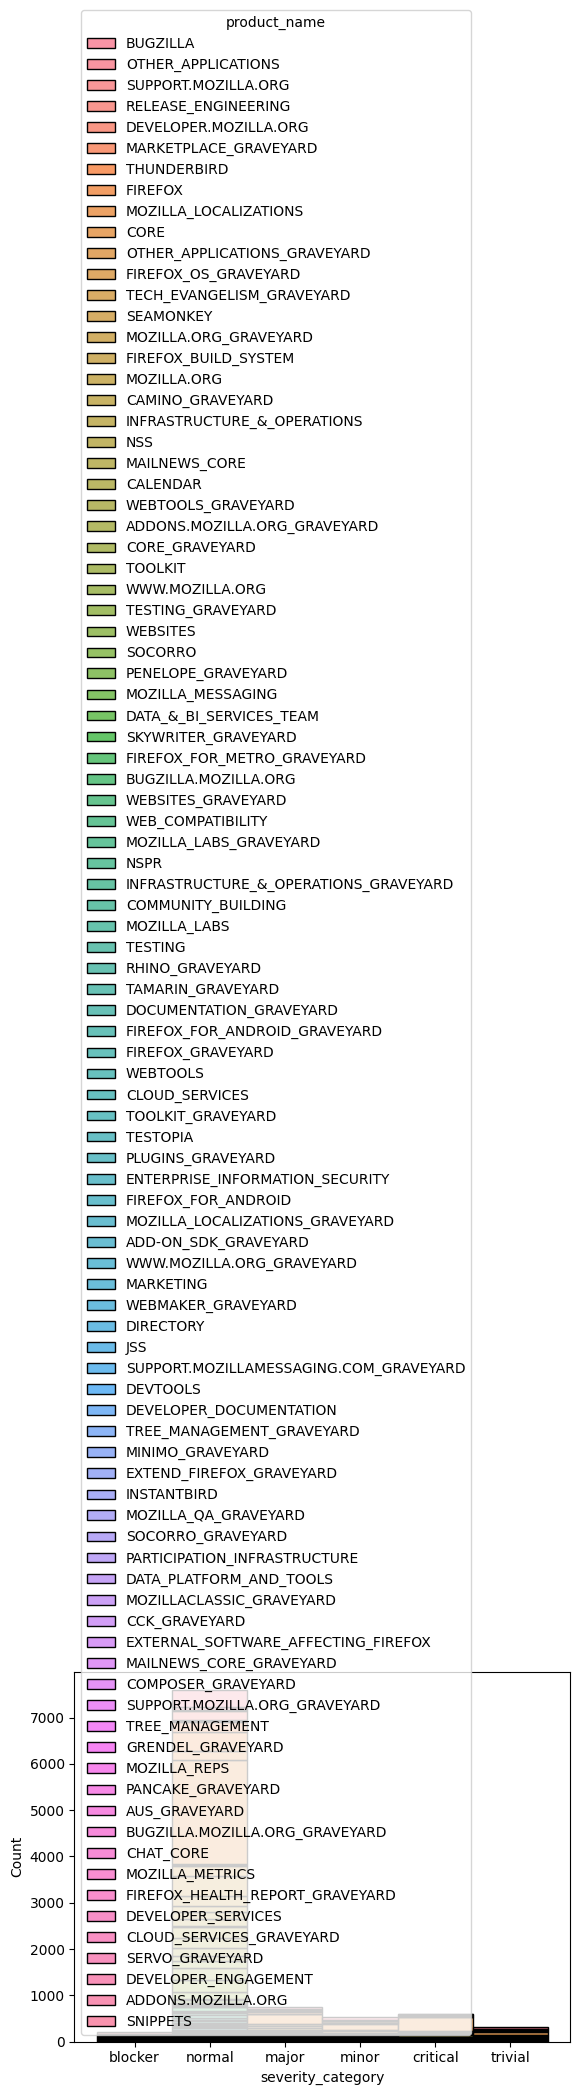

In [7]:
mapping_product_name = data.groupby(['severity_category', 'product_name']).size().reset_index(name='count')
print(mapping_product_name)

sn.histplot(data, x="severity_category", hue="product_name", multiple="stack")

     severity_category            component_name  count
0              blocker           Add-ons Manager      1
1              blocker            Administration      3
2              blocker                    Alarms      1
3              blocker        Application Update      2
4              blocker       Bookmarks & History      2
...                ...                       ...    ...
1326           trivial  nb-NO / Norwegian Bokmål      1
1327           trivial                nl / Dutch      2
1328           trivial        planet.mozilla.org      1
1329           trivial              sr / Serbian      1
1330           trivial           sv-SE / Swedish      1

[1331 rows x 3 columns]


D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)


<Axes: xlabel='severity_category', ylabel='Count'>

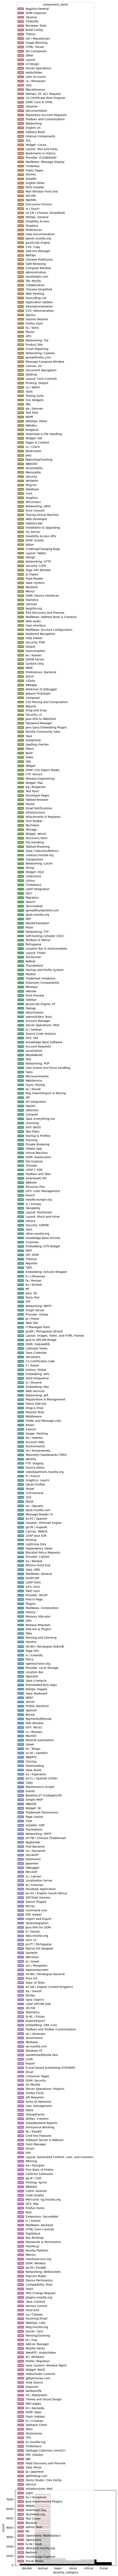

In [8]:
# 2. Component name
mapping_component_name = data.groupby(['severity_category', 'component_name']).size().reset_index(name='count')
print(mapping_component_name)

sn.histplot(data, x="severity_category", hue="component_name", multiple="stack")

In [9]:
# 3. Resolution Category
mapping_resolution_category = data.groupby(['severity_category', 'resolution_category']).size().reset_index(name='count')
print(mapping_resolution_category)

  severity_category resolution_category  count
0           blocker               fixed    205
1          critical               fixed    606
2             major               fixed    738
3             minor               fixed    541
4            normal               fixed   7604
5           trivial               fixed    305


   severity_category status_category  count
0            blocker          closed      1
1            blocker        resolved    204
2           critical          closed      3
3           critical        resolved    603
4              major          closed      1
5              major        resolved    737
6              minor          closed      1
7              minor        resolved    540
8             normal          closed     17
9             normal        resolved   7587
10           trivial          closed      1
11           trivial        resolved    304


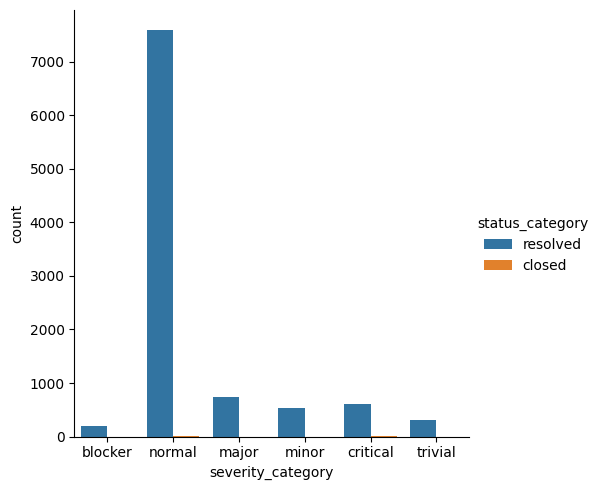

In [10]:
# 4. Status Category
mapping_status_category = data.groupby(['severity_category', 'status_category']).size().reset_index(name='count')
print(mapping_status_category)
sn.catplot(data, x="severity_category", hue="status_category", kind="count")

  severity_category  total_quantity_of_comments
0           blocker                        2672
1          critical                       10523
2             major                       12123
3             minor                        5648
4            normal                       94269
5           trivial                        2451


<Axes: xlabel='severity_category', ylabel='quantity_of_comments'>

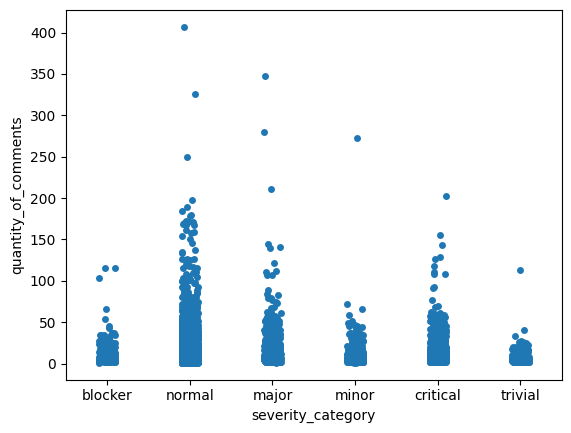

In [11]:
# 5. Quantity of comments
mapping_quantity_of_comments = data.groupby('severity_category')['quantity_of_comments'].sum().reset_index(name='total_quantity_of_comments')
print(mapping_quantity_of_comments)

sn.stripplot(data, x="severity_category", y="quantity_of_comments")

  severity_category  average_bug_fix_time
0           blocker             43.790244
1          critical            174.288779
2             major            268.890244
3             minor            308.981516
4            normal            292.047607
5           trivial            261.577049


<Axes: xlabel='severity_category', ylabel='bug_fix_time'>

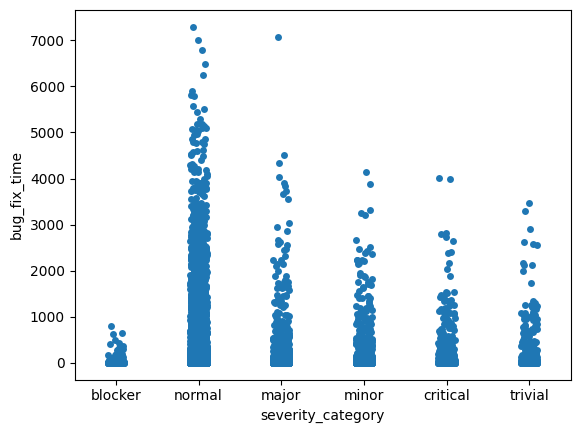

In [12]:
# 5. Quantity of comments
mapping_quantity_of_comments = data.groupby('severity_category')['bug_fix_time'].mean().reset_index(name='average_bug_fix_time')
print(mapping_quantity_of_comments)

sn.stripplot(data, x="severity_category", y="bug_fix_time")

In [13]:
# Based on my data exploration, the data had largest imbalance on "normal" category 
# Most of bug report activities are in "normal" category